In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch.optim as optim
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torchmetrics import Accuracy, F1Score

In [3]:
import os
import pandas as pd

data_path = "/kaggle/input/textclassificationarabic"

texts = []
labels = []

for category in os.listdir(data_path):
    category_path = os.path.join(data_path, category)
    if os.path.isdir(category_path):
        for file_name in os.listdir(category_path):
            file_path = os.path.join(category_path, file_name)
            with open(file_path, 'r', encoding='utf-8') as file:
                texts.append(file.read())
                labels.append(category)  

data = pd.DataFrame({'text': texts, 'category': labels})

print(data.head())
print(data['category'].value_counts())

                                                text category
0  أخبارنا المغربية ــ متابعة\nأعلنت شركة  " Gulf...  Finance
1  على الرغم من الظرفية الصعبة التي تمر منها أورو...  Finance
2  أخبارنا المغربية ــ سلا\nأعلن وزير التشغيل وال...  Finance
3  أخبارنا المغربية : الرباط   انتهت يوم أمس الأر...  Finance
4  أخبارنا المغربية:أكادير\nعلمت جريدة أخبارنا من...  Finance
category
Sports      15755
Politics    13979
Medical     12947
Tech        12199
Finance      9280
Religion     7522
Culture      6746
Name: count, dtype: int64


In [4]:
import re

def clean_text(text):
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)
    text = re.sub(r"[^ء-ي\s]", '', text)  # Conserver uniquement les caractères arabes et espaces
    text = re.sub(r'\s+', ' ', text).strip()
    return text

data['cleaned_text'] = data['text'].apply(clean_text)

print(data[['text', 'cleaned_text']].head())

                                                text  \
0  أخبارنا المغربية ــ متابعة\nأعلنت شركة  " Gulf...   
1  على الرغم من الظرفية الصعبة التي تمر منها أورو...   
2  أخبارنا المغربية ــ سلا\nأعلن وزير التشغيل وال...   
3  أخبارنا المغربية : الرباط   انتهت يوم أمس الأر...   
4  أخبارنا المغربية:أكادير\nعلمت جريدة أخبارنا من...   

                                        cleaned_text  
0  أخبارنا المغربية ــ متابعة أعلنت شركة البريطان...  
1  على الرغم من الظرفية الصعبة التي تمر منها أورو...  
2  أخبارنا المغربية ــ سلا أعلن وزير التشغيل والش...  
3  أخبارنا المغربية الرباط انتهت يوم أمس الأربعاء...  
4  أخبارنا المغربيةأكادير علمت جريدة أخبارنا من م...  


In [5]:
data['text_length'] = data['cleaned_text'].apply(lambda x: len(x.split()))
print("Average sentence lenght :", data['text_length'].mean())

max_length = 512
data['truncated_text'] = data['cleaned_text'].apply(lambda x: ' '.join(x.split()[:max_length]))

Average sentence lenght : 244.73329678176162


In [6]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
data['label'] = label_encoder.fit_transform(data['category'])

print("Categories mapping :", dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))

Categories mapping : {'Culture': 0, 'Finance': 1, 'Medical': 2, 'Politics': 3, 'Religion': 4, 'Sports': 5, 'Tech': 6}


In [7]:
train_texts, test_texts, train_labels, test_labels = train_test_split(
    data['truncated_text'], data['label'], test_size=0.2, random_state=42
)

print(f"Training : {len(train_texts)}, Test : {len(test_texts)}")

Training : 62742, Test : 15686


In [8]:
tokenizer = AutoTokenizer.from_pretrained("aubmindlab/bert-base-arabertv2")

train_encodings = tokenizer(list(train_texts), truncation=True, padding=True, max_length=128)
test_encodings = tokenizer(list(test_texts), truncation=True, padding=True, max_length=128)

tokenizer_config.json:   0%|          | 0.00/611 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/384 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/720k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.31M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [9]:
from torch.utils.data import Dataset, DataLoader
import torch

class AkhbaronaDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}, torch.tensor(self.labels[idx])

train_dataset = AkhbaronaDataset(train_encodings, train_labels.tolist())
test_dataset = AkhbaronaDataset(test_encodings, test_labels.tolist())

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

In [10]:
from torch.nn import CrossEntropyLoss
from sklearn.metrics import classification_report

In [13]:
from sklearn.utils.class_weight import compute_class_weight
from transformers import get_scheduler
from transformers import AutoModelForSequenceClassification
from torch.optim import AdamW

model = AutoModelForSequenceClassification.from_pretrained("aubmindlab/bert-base-arabertv2", num_labels=len(data['label'].unique()))
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

class_weights = compute_class_weight('balanced', classes=np.unique(data['label']), y=data['label'])
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

optimizer = optim.AdamW(model.parameters(), lr=0.0001)
num_training_steps = len(train_loader) * 3  # Assuming 3 epochs
scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps)


criterion = nn.CrossEntropyLoss(weight=class_weights)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)

def train(model, train_loader, optimizer, criterion, scheduler, device):
    model.train()
    total_loss = 0
    for batch in train_loader:
        inputs = {key: val.to(device) for key, val in batch[0].items()}
        labels = batch[1].to(device)

        optimizer.zero_grad()

        outputs = model(**inputs)
        loss = criterion(outputs.logits, labels)
        total_loss += loss.item()

        loss.backward()
        optimizer.step()
        scheduler.step()

    return total_loss / len(train_loader)

def evaluate(model, test_loader, device):
    model.eval()
    predictions = []
    true_labels = []
    with torch.no_grad():
        for batch in test_loader:
            inputs = {key: val.to(device) for key, val in batch[0].items()}
            labels = batch[1].to(device)

            outputs = model(**inputs)
            preds = torch.argmax(outputs.logits, dim=1)

            predictions.extend(preds.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    print("Classification Report:\n", classification_report(true_labels, predictions))
    return true_labels, predictions

epochs = 3
for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")
    train_loss = train(model, train_loader, optimizer, criterion, scheduler, device)
    print(f"Training Loss  : {train_loss}")

print("\nEvaluation on Test Data :")
true_labels, predictions = evaluate(model, test_loader, device)

model.save_pretrained("bert-akhbarona-model")
tokenizer.save_pretrained("bert-akhbarona-model")
print("Model saved in the folder 'bert-akhbarona-model'")

model.safetensors:   0%|          | 0.00/543M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at aubmindlab/bert-base-arabertv2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3
Training Loss  : 0.28844970294411165
Epoch 2/3
Training Loss  : 0.13394587425040608
Epoch 3/3
Training Loss  : 0.11182724219415155

Evaluation on Test Data :
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.93      0.93      1319
           1       0.87      0.88      0.88      1851
           2       0.96      0.97      0.96      2643
           3       0.92      0.90      0.91      2698
           4       0.96      0.98      0.97      1560
           5       0.99      0.99      0.99      3221
           6       0.96      0.95      0.95      2394

    accuracy                           0.95     15686
   macro avg       0.94      0.94      0.94     15686
weighted avg       0.95      0.95      0.95     15686

Model saved in the folder 'bert-akhbarona-model'


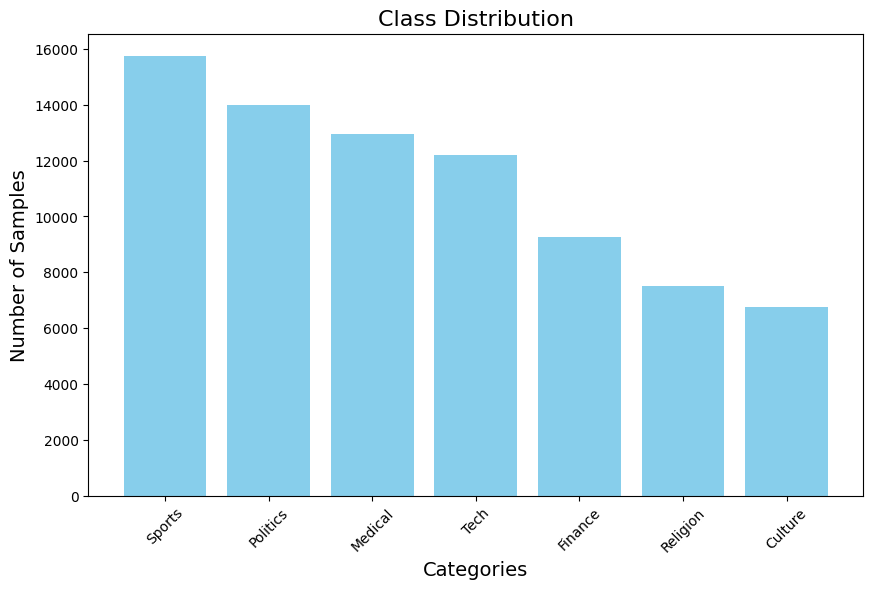

In [14]:
import matplotlib.pyplot as plt

class_counts = data['label'].value_counts()
class_names = class_counts.index.map(lambda x: ['Culture', 'Finance', 'Medical', 'Politics', 'Religion', 'Sports', 'Tech'][x])

plt.figure(figsize=(10, 6))
plt.bar(class_names, class_counts.values, color='skyblue')
plt.title("Class Distribution", fontsize=16)
plt.xlabel("Categories", fontsize=14)
plt.ylabel("Number of Samples", fontsize=14)
plt.xticks(rotation=45)
plt.show()

In [ ]:
plt.figure(figsize=(8, 8))
plt.pie(class_counts.values, labels=class_names, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired.colors)
plt.title("Class Distribution", fontsize=16)
plt.show()


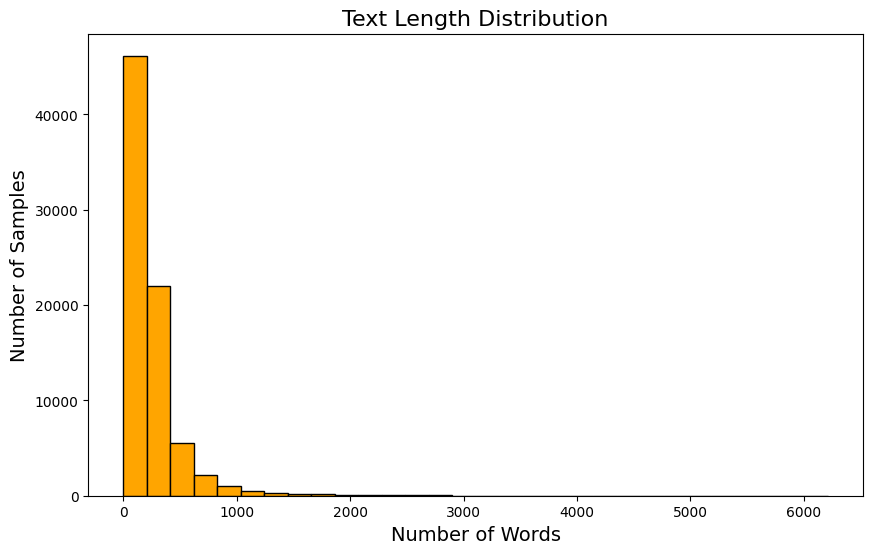

In [15]:
text_lengths = data['text'].apply(lambda x: len(x.split()))

plt.figure(figsize=(10, 6))
plt.hist(text_lengths, bins=30, color='orange', edgecolor='black')
plt.title("Text Length Distribution", fontsize=16)
plt.xlabel("Number of Words", fontsize=14)
plt.ylabel("Number of Samples", fontsize=14)
plt.show()

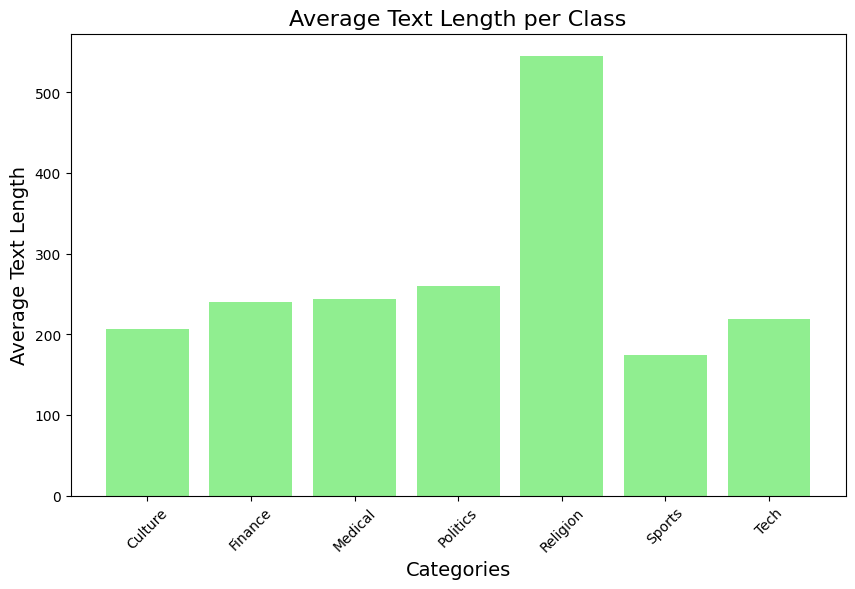

In [16]:
avg_text_lengths = data.groupby('label')['text'].apply(lambda x: x.str.split().str.len().mean())
class_names = avg_text_lengths.index.map(lambda x: ['Culture', 'Finance', 'Medical', 'Politics', 'Religion', 'Sports', 'Tech'][x])

plt.figure(figsize=(10, 6))
plt.bar(class_names, avg_text_lengths.values, color='lightgreen')
plt.title("Average Text Length per Class", fontsize=16)
plt.xlabel("Categories", fontsize=14)
plt.ylabel("Average Text Length", fontsize=14)
plt.xticks(rotation=45)
plt.show()

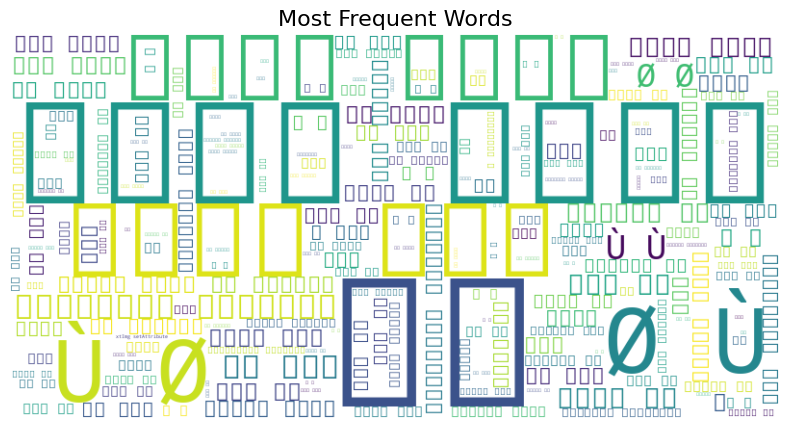

In [17]:
from wordcloud import WordCloud

all_text = " ".join(data['text'])

wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate(all_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Most Frequent Words", fontsize=16)
plt.show()

In [18]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer

model = AutoModelForSequenceClassification.from_pretrained("bert-akhbarona-model")
tokenizer = AutoTokenizer.from_pretrained("bert-akhbarona-model")

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

new_text = "الاقتصاد في العالم يشهد تغيرات كبيرة في الآونة الأخيرة."
cleaned_text = clean_text(new_text)  
inputs = tokenizer(cleaned_text, truncation=True, padding=True, max_length=128, return_tensors="pt").to(device)

model.eval()
with torch.no_grad():
    outputs = model(**inputs)
    prediction = torch.argmax(outputs.logits, dim=1)

predicted_label = label_encoder.inverse_transform(prediction.cpu().numpy())[0]
print("Predicted Category :", predicted_label)

Predicted Category : Finance


In [28]:
class MultiHeadDifferentialAttention(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super(MultiHeadDifferentialAttention, self).__init__()
        self.num_heads = num_heads
        self.embed_dim = embed_dim
        self.head_dim = embed_dim // num_heads
        
        assert (
            self.head_dim * num_heads == embed_dim
        ), "embed_dim doit être divisible par num_heads."
        
        
        self.query = nn.Linear(embed_dim, embed_dim)
        self.key = nn.Linear(embed_dim, embed_dim)
        self.value = nn.Linear(embed_dim, embed_dim)
        
        
        self.fc_out = nn.Linear(embed_dim, embed_dim)

    def forward(self, hidden_states):
        batch_size, seq_length, embed_dim = hidden_states.size()
        
        
        Q = self.query(hidden_states)
        K = self.key(hidden_states)
        V = self.value(hidden_states)
        
        
        Q = Q.view(batch_size, seq_length, self.num_heads, self.head_dim).transpose(1, 2)
        K = K.view(batch_size, seq_length, self.num_heads, self.head_dim).transpose(1, 2)
        V = V.view(batch_size, seq_length, self.num_heads, self.head_dim).transpose(1, 2)
        
        
        attention_scores = torch.matmul(Q, K.transpose(-1, -2)) / (self.head_dim ** 0.5)
        attention_probs = torch.softmax(attention_scores, dim=-1)
        
        
        attention_output = torch.matmul(attention_probs, V)
        
        
        attention_output = attention_output.transpose(1, 2).contiguous().view(batch_size, seq_length, embed_dim)
        output = self.fc_out(attention_output)
        
        return output


In [29]:
class ModifiedBERTWithMHDA(nn.Module):
    def __init__(self, pretrained_model_name, num_labels, embed_dim=768, num_heads=8):
        super(ModifiedBERTWithMHDA, self).__init__()
        self.bert = AutoModel.from_pretrained(pretrained_model_name)
        self.mhda = MultiHeadDifferentialAttention(embed_dim=embed_dim, num_heads=num_heads)
        self.classifier = nn.Linear(embed_dim, num_labels)

    def forward(self, input_ids, attention_mask, token_type_ids=None):
        
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        sequence_output = outputs.last_hidden_state  # Tensor de taille (batch_size, seq_len, embed_dim)
        
        attention_output = self.mhda(sequence_output)
        
        cls_token_output = attention_output[:, 0, :]
        
        logits = self.classifier(cls_token_output)
        return logits


In [30]:
tokenizer = AutoTokenizer.from_pretrained("aubmindlab/bert-base-arabertv2")


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [34]:
from transformers import AutoModel
model = ModifiedBERTWithMHDA(pretrained_model_name="aubmindlab/bert-base-arabertv2", num_labels=7)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)



class_weights = compute_class_weight('balanced', classes=np.unique(data['label']), y=data['label'])
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)


num_training_steps = len(train_loader) * 3 
scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps)

optimizer = optim.AdamW(model.parameters(), lr=5e-5)
criterion = nn.CrossEntropyLoss(weight=class_weights)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

In [35]:

def train(model, train_loader, optimizer, criterion, scheduler, device):
    model.train()
    total_loss = 0
    for batch in train_loader:
        inputs = {key: val.to(device) for key, val in batch[0].items()}
        labels = batch[1].to(device)

        optimizer.zero_grad()

        outputs = model(**inputs)
        loss = criterion(outputs, labels)
        total_loss += loss.item()

        loss.backward()
        optimizer.step()
        if scheduler:
            scheduler.step()

    return total_loss / len(train_loader)

def evaluate(model, test_loader, device):
    model.eval()
    predictions = []
    true_labels = []
    with torch.no_grad():
        for batch in test_loader:
            inputs = {key: val.to(device) for key, val in batch[0].items()}
            labels = batch[1].to(device)

            outputs = model(**inputs)
            preds = torch.argmax(outputs, dim=1)

            predictions.extend(preds.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    print("Classification Report:\n", classification_report(true_labels, predictions))
    return true_labels, predictions

In [36]:
epochs = 3
for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")
    train_loss = train(model, train_loader, optimizer, criterion, scheduler, device)
    print(f"Training Loss  : {train_loss}")

print("\nEvaluation on Test Data :")
true_labels, predictions = evaluate(model, test_loader, device)

model.save_pretrained("bert-mhda-akhbarona-model")
tokenizer.save_pretrained("bert-mhda-akhbarona-model")
print("Model saved in the folder 'bert-mhda-akhbarona-model'")

Epoch 1/3
Training Loss  : 0.6743004079043774
Epoch 2/3
Training Loss  : 0.353801087855776
Epoch 3/3
Training Loss  : 0.5529557837086432

Evaluation on Test Data :
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.93      0.91      1319
           1       0.86      0.86      0.86      1851
           2       0.94      0.97      0.96      2643
           3       0.92      0.89      0.90      2698
           4       0.98      0.96      0.97      1560
           5       0.98      0.99      0.99      3221
           6       0.95      0.94      0.95      2394

    accuracy                           0.94     15686
   macro avg       0.93      0.93      0.93     15686
weighted avg       0.94      0.94      0.94     15686



AttributeError: 'ModifiedBERTWithMHDA' object has no attribute 'save_pretrained'